In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plot
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

pd.options.display.max_columns = 50
pd.options.display.max_rows = 80

####Сервис

In [2]:
'''
В этой строчке кода содержатся гиперпараметры (бюджет компании, расценки, конверсия), которые задаются пользователем
'''

#бюджет компании
budget = 1000

#стоимость коммуникации
cost_email = 2
cost_sms = 10

#конверсия
conversion_email = 0.2
conversion_sms = 0.8

#ограничения по коммуникации (в %)
max_email = 0.6
max_sms = 0.4

In [3]:
#загрузим тестовые и трейновые данные
df_train = pd.read_csv('WORK_bank_data_train.csv', sep=';')
df_test = pd.read_csv('WORK_WORK_BANK_DATA_test_sample.csv', sep=';') #файл может быть изменен пользователем

#ценность клиента, рассчитываемая по переменной trans_3_month - транзакции за последние три месяца
#(сохраним только для тестовой выборки)
client_importance = df_test.trans_3_month / df_train.trans_3_month.max()

In [4]:
'''
Функция, которая принимает на вход датафрейм, обрабатывает его и выдает данные, готовые для построения моделей
'''

def data_preparation(df, is_train=True):
    
    def encoder(data, columns):
        for column in columns:
            tmp = pd.get_dummies(data[column], prefix=column)
            data = data.drop(columns=[column])
            data = data.join(tmp)
        return data
    
    def code(data, columns):
        for column in columns:
            data[column] = 1 * (data[column] == 'Yes')
        return data

    df['Age'].fillna(round(df['Age'].mean(), 0), inplace=True)
    df['Lifetime'].fillna(round(df['Lifetime'].mean(), 0), inplace=True)
    
    if not is_train:
        df.rename(columns = {'Ind_House_hold' : 'Ind_Household'}, inplace = True)
    
    columns_to_delete_train = ['Ind_email', 'Ind_phone']

    columns_to_delete = ["Ind_Household", "District", "Ind_deposit", "Ind_salary",
                      "trans_6_month", "trans_9_month", "trans_12_month", "amont_trans",
                      "trans_3_month"] #IV < 0.01

    if is_train:
        columns_to_label_encoding = ['Target1', 'Target2']
        df = code(df, columns=columns_to_label_encoding)
        df.drop(columns=columns_to_delete_train, inplace=True)

    df.drop(columns=columns_to_delete, inplace=True)
    
    columns_to_encoder = ['Age_group', 'Region', 'Segment', 'Gender']
    df = encoder(df, columns=columns_to_encoder)

    df.drop(columns=["Region_Unknown", "Gender_U", "Age_group_unknown"], inplace=True)
    
    return df

In [5]:
#обработка данных
df_train = data_preparation(df_train)
df_test = data_preparation(df_test, False)

#делим данные на регрессоры и два таргета
y1 = df_train.loc[:, ['Target1']] #колонка таргета 1
y2 = df_train.loc[:, ['Target2']] #колонка таргета 2
x = df_train.drop(columns = ['Target1', 'Target2']) #фичи

#лучшая модель для таргета 1 (e-mail)
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb_best_for_email = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=10,
        min_child_weight=4,
        gamma=0.4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        objective='binary:logistic',  
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb_best_for_email.fit(x, y1.values)

df_test['prob_email'] = xgb_best_for_email.predict_proba(df_test)[:, 1]

#лучшая модель для таргета 1 (sms)

xgb_best_for_sms = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=15,
        min_child_weight=1,
        gamma=0.9,
        subsample=0.9,
        colsample_bytree=0.6,
        reg_alpha=0.01,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb_best_for_sms.fit(x, y2.values)

df_test['prob_sms'] = xgb_best_for_sms.predict_proba(df_test.drop(columns=['prob_email']))[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
'''
Алгоритм для определения вероятностей отклика на коммуникацию с учетом ценности клиента и конверсии
'''

def client_probabilities(df):

    #добавим вероятности отклика на каждую коммуникацю в таблицу и добавим столбец ценности каждого клиента
    df['client_importance'] = client_importance

    #преобразуем вероятности отклика на каждую коммуникацию с учетом конверсии и ценности клиента
    df['prob_email_imp_conv'] = df['prob_email'] * df['client_importance'] * conversion_email
    df['prob_sms_imp_conv'] = df['prob_sms'] * df['client_importance'] * conversion_sms

    #выберем колонку с наибольшей вероятностью для каждого клиента (и создадим еще одну переменную, которая будет означать,
    #какая коммуникация для этого клиента подходит (email, sms))
    df['communication'] = 'None'
    for i in range(0, len(df)):
      if df.iloc[i]['prob_email_imp_conv'] >= df.iloc[i]['prob_sms_imp_conv']:
        df.at[i, 'communication'] = 'email'
      else:
        df.at[i, 'communication'] = 'sms'
  
    #создадим колонку с общими вероятностями для сортировки клиентом (выбираем отклик, на который клиент вероятнее всего откликнется)
    df['probs_for_sort'] = df[['prob_email_imp_conv', 'prob_sms_imp_conv']].max(axis = 1)

    #отсортируем клиентов по вероятности отклика
    df = df.sort_values(by=['probs_for_sort'], ascending=False)
    df = df.reset_index(drop=True)

    return df

In [7]:
df_test = client_probabilities(df_test)

In [40]:
min_budget = 1000
max_budget = 60000

In [41]:
import random
random_response = []
optim_response = []
# посчитаем чумарную вероятность отклика клиентов на случайную рассылку
for budget in range(min_budget, max_budget, 3000):
  num_email = budget * max_email / cost_email
  num_sms = budget * max_sms / cost_sms
  random_clients_email = random.sample(range(0, len(df_test)), int(num_email))
  random_clients_sms = random.sample(range(0, len(df_test)), int(num_sms))
  random_response.append(df_test.iloc[random_clients_email]['prob_email_imp_conv'].sum()+ df_test.iloc[random_clients_sms]['prob_sms_imp_conv'].sum())
  
  results = pd.DataFrame(columns=['ID', 'communication_type', 'prob_responce'])
  n_email = 0
  n_sms = 0
  clients_for_email = []
  clients_for_sms = []
  type_email = []
  type_sms = []
  prob_responce = []
  for i in range(0, len(df_test)):
    if n_email == num_email:
      break 
    if df_test.iloc[i]['communication'] == 'email':
      clients_for_email.append(df_test.iloc[i]['ID']) 
      type_email.append(df_test.iloc[i]['communication'])
      prob_responce.append(df_test.iloc[i]['prob_email']*conversion_email)
      n_email += 1
  for i in range(0, len(df_test)):
    if n_sms == num_sms:
      break 
    if df_test.iloc[i]['communication'] == 'sms':
      clients_for_sms.append(df_test.iloc[i]['ID'])
      type_sms.append(df_test.iloc[i]['communication']) 
      prob_responce.append(df_test.iloc[i]['prob_sms']*conversion_sms) 
      n_sms += 1
  ids = clients_for_email + clients_for_sms
  communication_type = type_email + type_sms
  results = pd.DataFrame({'ID': ids, 'communication_type': communication_type, 'prob_responce' : prob_responce})
  optim_response.append(results.prob_responce.sum()) 

In [42]:
y = np.arange(1000, 60000, 3000)

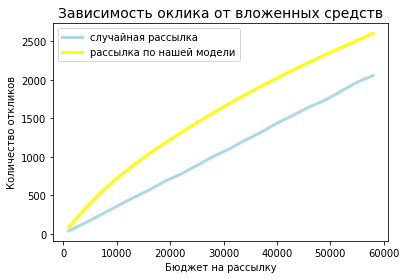

In [80]:
plt.plot(y, random_response, color = 'lightblue', linewidth = 3, label = 'случайная рассылка')
plt.plot(y, optim_response, color = 'yellow', linewidth = 3, label = 'рассылка по нашей модели')
plt.legend()
plt.title('Зависимость оклика от вложенных средств', fontsize = 14)
plt.xlabel("Бюджет на рассылку")
plt.ylabel("Количество откликов")
plt.savefig('saved_figure.jpg')

In [44]:
email_response = []
sms_response = []
for budget in range(1000, 60000, 3000):
  num_email = budget / cost_email
  num_sms = budget / cost_sms
  random_clients_email = random.sample(range(0, len(df_test)), int(num_email))
  random_clients_sms = random.sample(range(0, len(df_test)), int(num_sms))
  email_response.append(df_test.iloc[random_clients_email]['prob_email_imp_conv'].sum())
  sms_response.append(df_test.iloc[random_clients_sms]['prob_sms_imp_conv'].sum())

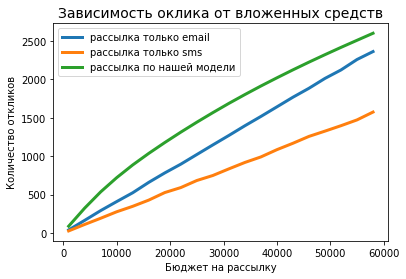

In [79]:
plt.plot(y, email_response, linewidth = 3, label = 'рассылка только email')
plt.plot(y, sms_response, linewidth = 3, label = 'рассылка только sms')
plt.plot(y, optim_response, linewidth = 3, label = 'рассылка по нашей модели')

plt.legend()
plt.title('Зависимость оклика от вложенных средств', fontsize = 14)
plt.xlabel("Бюджет на рассылку")
plt.ylabel("Количество откликов");